# Download ADCP data from the AODN

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map
from scipy import signal

#from myspectra import filt_decompose
from nwatides.filtering import filt_decompose

In [ ]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [175]:
# sitename = 'NWSBRW'
# filenum = 0
# outfile = '../DATA/IMOS_{}_202205_202210_uv.nc'.format(sitename)

# filenum = 1
# outfile = '../DATA/IMOS_{}_202210_202305_uv.nc'.format(sitename)

sitename = 'NWSBAR'
# filenum = 0
# outfile = '../DATA/IMOS_{}_202205_202210_uv.nc'.format(sitename)
filenum = 1
outfile = '../DATA/IMOS_{}_202210_202305_uv.nc'.format(sitename)


k = -10 # depth layer


In [176]:
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/ANMN/QLD/{}/Velocity'.format(sitename))
for item in aodn:
    print(item)

imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-Quartermaster-Workhorse-ADCP-156.7_END-20200218T002000Z_C-20200312T052431Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-Sentinel-or-Monitor-Workhorse-ADCP-158.2_END-20200218T002000Z_C-20200312T052416Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20200218T000210Z_NWSBAR_FV01_NWSBAR-2002-Quartermaster-Workhorse-ADCP-158_END-20201007T010000Z_C-20201104T040832Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20200218T000210Z_NWSBAR_FV01_NWSBAR-2002-Sentinel-or-Monitor-Workhorse-ADCP-159.5_END-20201007T010000Z_C-20201104T040815Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20201007T011000Z_NWSBAR_FV01_NWSBAR-2009-Quartermaster-Workhorse-ADCP-164.5_END-20210511T025000Z_C-20230817T012133Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20201007T011000Z_NWSBAR_FV01_NWSBAR

In [177]:
def open_file_nocache(fname):
    fileobj = fs.open(fname)
    return xr.open_dataset(fileobj)


In [178]:
fs = S3FileSystem(anon=True)
aodn = fs.glob('imos-data/IMOS/ANMN/QLD/{}/Velocity/*Signature100*.nc'.format(sitename))
for item in aodn:
    print(item)

imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20220510T034900Z_NWSBAR_FV01_NWSBAR-2204-Signature100-157.9_END-20220912T235400Z_C-20230817T031130Z.nc
imos-data/IMOS/ANMN/QLD/NWSBAR/Velocity/IMOS_ANMN-QLD_AETVZ_20221024T060000Z_NWSBAR_FV01_NWSBAR-2210-Signature100-163.2_END-20230513T040457Z_C-20230817T034747Z.nc


In [179]:
ds = open_file_nocache(aodn[filenum])
ds

<xarray.Dataset>
Dimensions:                   (TIME: 29145, HEIGHT_ABOVE_SENSOR: 25)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2022-10-22T23:59:53.00110...
  * HEIGHT_ABOVE_SENSOR       (HEIGHT_ABOVE_SENSOR) float32 12.0 20.0 ... 204.0
    LATITUDE                  float64 ...
    LONGITUDE                 float64 ...
    NOMINAL_DEPTH             float32 ...
Data variables: (12/37)
    TIMESERIES                int32 ...
    TEMP                      (TIME) float32 ...
    TEMP_quality_control      (TIME) float32 ...
    PRES_REL                  (TIME) float32 ...
    PRES_REL_quality_control  (TIME) float32 ...
    SSPD                      (TIME) float32 ...
    ...                        ...
    DEPTH                     (TIME) float32 ...
    DEPTH_quality_control     (TIME) float32 ...
    CSPD                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CSPD_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CDIR                      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
    CDIR_quality_control      (TIME, HEIGHT_ABOVE_SENSOR) float32 ...
Attributes: (12/59)
    abstract:                      The Queensland and Northern Australia moor...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Australian Institute of Marine Science
    author_email:                  adc@aims.gov.au
    cdm_data_type:                 Station
    citation:                      The citation in a list of references is: "...
    ...                            ...
    time_deployment_start:         2022-10-24T06:00:00Z
    time_deployment_start_origin:  TimeFirstGoodData
    title:                         Barrow Islands Deployed 24/10/2022 Trip 7881.
    toolbox_input_file:            C:\Users\tarmstro\Desktop\Moorings\NWS\NWS...
    toolbox_parser:                OceanContour
    toolbox_version:               2.6.15 - PCWIN64

In [180]:
def get_vel_qc_aodn(ds,varname='UCUR'):

    badidx = ds['{}_quality_control'.format(varname)].values <2
    temp = ds['{}'.format(varname)]
    return temp.where(badidx, np.nan)


In [181]:
u = get_vel_qc_aodn(ds, varname='UCUR').isel(HEIGHT_ABOVE_SENSOR=k)
v = get_vel_qc_aodn(ds, varname='VCUR').isel(HEIGHT_ABOVE_SENSOR=k)

# ds_out = xr.merge([u.dropna('TIME'), v.dropna('TIME')])
ds_out = xr.merge([u, v])

ds_out

<xarray.Dataset>
Dimensions:              (TIME: 29145)
Coordinates:
  * TIME                 (TIME) datetime64[ns] 2022-10-22T23:59:53.001104128 ...
    HEIGHT_ABOVE_SENSOR  float32 132.0
    LATITUDE             float64 -20.76
    LONGITUDE            float64 114.8
    NOMINAL_DEPTH        float32 163.2
Data variables:
    UCUR                 (TIME) float32 nan nan nan nan nan ... nan nan nan nan
    VCUR                 (TIME) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    ancillary_variables:         UCUR_quality_control
    comment:                     magneticDeclinationPP: data initially referr...
    compass_correction_applied:  0.5166666666666667
    long_name:                   eastward_sea_water_velocity
    magnetic_declination:        0.5166666666666667
    reference_datum:             true north
    standard_name:               eastward_sea_water_velocity
    units:                       m s-1
    valid_max:                   10.0
    valid_min:                   -10.0

In [182]:
ds_out.to_netcdf(outfile)
print(outfile)

../DATA/IMOS_NWSBAR_202210_202305_uv.nc


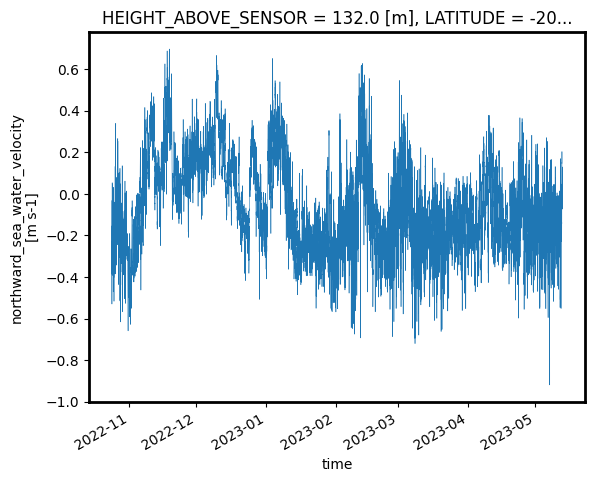

In [183]:
plt.figure()
v.plot(lw=0.4)

In [184]:
dt = (u.TIME[2]-u.TIME[1]).values.astype('float')/1e9
dt

600.000004608

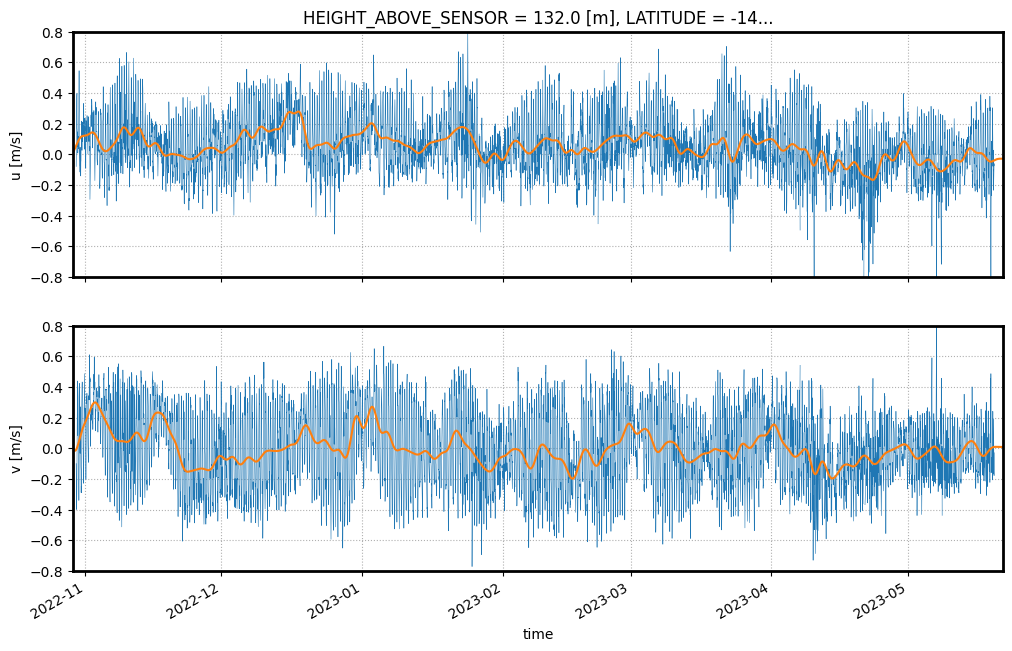

In [140]:
utmp = u.values*1
utmp[np.isnan(utmp)] = 0.
uf = filt_decompose(utmp, dt,)

utmp = v.values*1
utmp[np.isnan(utmp)] = 0.
vf = filt_decompose(utmp, dt,)


plt.figure(figsize=(12,7))
ax=plt.subplot(211)
u.plot(lw=0.4)
plt.plot(u.TIME, uf[:,0])
plt.ylim(-0.8,0.8)
plt.xlim(u.TIME[0],u.TIME[-1])
plt.ylabel('u [m/s]')
ax.set_xticklabels([])
plt.grid(True, ls=':')
plt.xlabel('')

ax=plt.subplot(212)
v.plot(lw=0.4)
plt.plot(u.TIME, vf[:,0])
plt.ylim(-0.8,0.8)
plt.xlim(u.TIME[0],u.TIME[-1])
plt.title('')
plt.ylabel('v [m/s]')
plt.grid(True, ls=':')

# plt.savefig('../FIGURES/RowleyShoals_Currents_30m_bMSL.png', dpi=150)

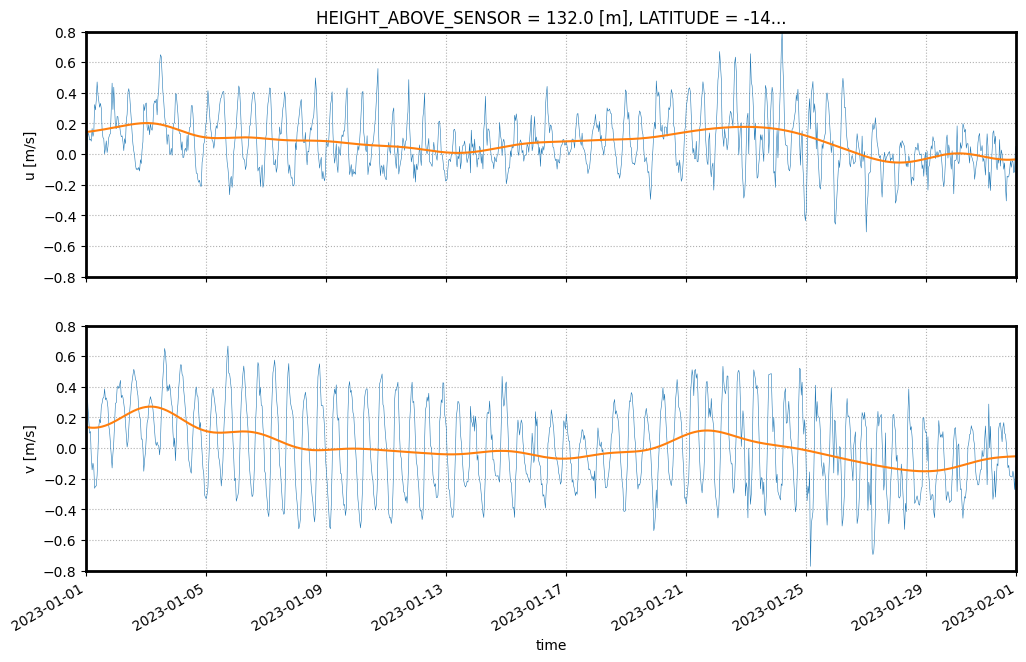

In [145]:
# t1,t2 = u.TIME[0],u.TIME[-1]
t1,t2 = np.datetime64('2022-06-01'), np.datetime64('2022-08-01')
t1,t2 = np.datetime64('2023-01-01'), np.datetime64('2023-02-01')

plt.figure(figsize=(12,7))
ax=plt.subplot(211)
u.plot(lw=0.4)
plt.plot(u.TIME, uf[:,0])
plt.ylim(-0.8,0.8)
plt.xlim(t1,t2)
plt.ylabel('u [m/s]')
ax.set_xticklabels([])
plt.grid(True, ls=':')
plt.xlabel('')

ax=plt.subplot(212)
v.plot(lw=0.4)
plt.plot(u.TIME, vf[:,0])
plt.ylim(-0.8,0.8)
plt.xlim(t1,t2)
plt.title('')
plt.ylabel('v [m/s]')
plt.grid(True, ls=':')

# plt.savefig('../FIGURES/RowleyShoals_Currents_30m_bMSL_SepNov2019.png', dpi=150)

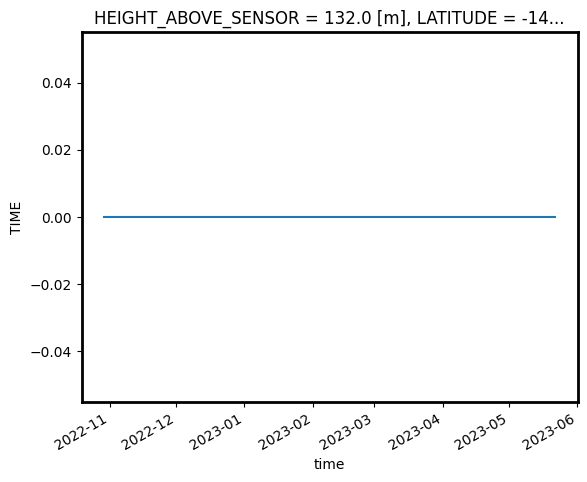

In [142]:
dt = (u.TIME[1::]-u.TIME[0:-1]).astype('float')/1e9
dt.plot()

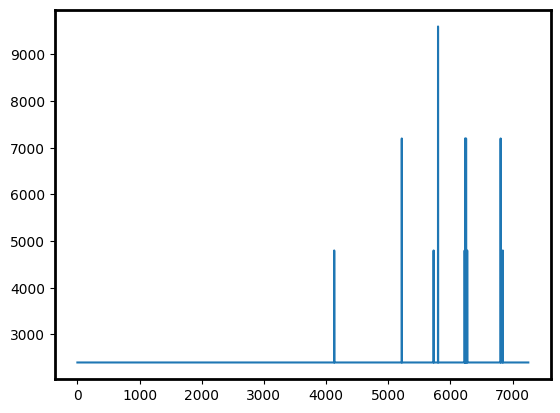

In [143]:
dt = (ds_out.TIME.values[1::]-ds_out.TIME.values[0:-1]).astype('float')/1e9
plt.plot(dt)